## Load dataset and train classifier

In [1]:
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

In [2]:
from intabs.dataset import InnDataSet
data_name = "compas"
dataset = InnDataSet(data_name)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.
 [lazy_loader.py _load]


In [3]:
from intabs.classifier_binary import cross_validation, train_clf, InnModel
d = dataset
num_h_neurons = 8
epochs = 20
cross_validation(d, num_h_neurons, epochs, data_name)

Using cuda device
accuracy: 0.8437601296596435+-0.009539020401661057


In [4]:
torch_model = train_clf(d.X1_train, d.y1_train, d.X1_test, d.y1_test, num_h_neurons, epochs, data_name, save_clf=False, load_clf=False)
model = InnModel(d, torch_model, num_h_neurons)

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.695     0.291     0.411       470
good credit (1)      0.853     0.970     0.908      1998

       accuracy                          0.841      2468
      macro avg      0.774     0.631     0.659      2468
   weighted avg      0.823     0.841     0.813      2468

Evaluations on testing data

                  precision    recall  f1-score   support

 bad credit (0)      0.686     0.299     0.417       117
good credit (1)      0.855     0.968     0.908       500

       accuracy                          0.841       617
      macro avg      0.771     0.634     0.662       617
   weighted avg      0.823     0.841     0.815       617



## Experiments 1

First, get $\delta$ value using incremental retraining, and get $\delta$ value using validation set

In [5]:
from intabs.evaluation import get_delta_incremental_training, get_retrained_models_and_validation_set, test_delta_with_val_set
percentages, delta_magnitudes = get_delta_incremental_training(d, model, batch_size=32)
inc_delta = delta_magnitudes[5].round(5) # select the delta value corresponding to retraining on 10% size of original data

100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


In [6]:
rt_models, val_set, val_y_set = get_retrained_models_and_validation_set(d, model)

100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


In [7]:
val_delta = 0.02
#print(test_delta_with_val_set(d, model, val_delta, val_set, rt_models))

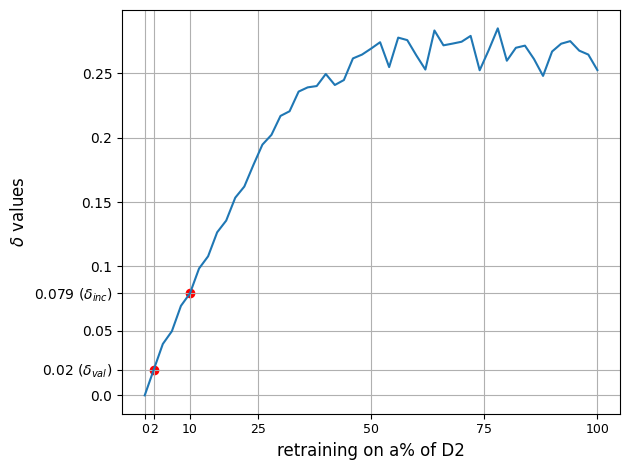

In [8]:
# plot
from intabs.evaluation import plot_deltas
plot_deltas(val_delta, inc_delta, percentages, delta_magnitudes, data_name)

## Experiments 2

Evaluating $\Delta$-robustness

In [9]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from intabs.evaluation import *
test_set, test_set_df, test_set_full_df = get_test_inputs(d, model, 50)

In [10]:
from intabs.methods import roar, gce, mce, gce_r, mce_r, proto_r, rnce
deltas_plot = get_deltas_plot(inc_delta, val_delta)

In [11]:
roar_ces_plot = roar(test_set_full_df, model, lr=0.02, lambda_=0.001, delta_max=inc_delta)
roar_delta_validity = delta_robustness_test_for_plots(d, model, roar_ces_plot, deltas_plot)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14


In [12]:
gce_ces_plot = gce(test_set, model)
gce_delta_validity = delta_robustness_test_for_plots(d, model, gce_ces_plot, deltas_plot)

In [13]:
mce_ces_plot = mce(test_set, d, model)
mce_delta_validity = delta_robustness_test_for_plots(d, model, mce_ces_plot, deltas_plot)

In [14]:
proto_ces_plot = proto_r(test_set, d, model, plain=True)
proto_delta_validity = delta_robustness_test_for_plots(d, model, proto_ces_plot, deltas_plot)

0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]
[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]


50it [23:34, 28.29s/it]


In [15]:
gcer_ces_plot = gce_r(test_set, d, model, delta=inc_delta)
gcer_delta_validity = delta_robustness_test_for_plots(d, model, gcer_ces_plot, deltas_plot)

50it [07:44,  9.29s/it]


In [16]:
mcer_ces_plot = mce_r(test_set, d, model, delta=inc_delta)
mcer_delta_validity = delta_robustness_test_for_plots(d, model, mcer_ces_plot, deltas_plot)

50it [00:57,  1.15s/it]


In [17]:
protor_ces_plot = proto_r(test_set, d, model, delta=inc_delta, plain=False, plain_proto_ces=proto_ces_plot)
protor_delta_validity = delta_robustness_test_for_plots(d, model, protor_ces_plot, deltas_plot)

50it [1:21:10, 97.42s/it] 


In [18]:
rnce_ces_plot = rnce(test_set, d, model, delta=inc_delta)
rnce_delta_validity = delta_robustness_test_for_plots(d, model, rnce_ces_plot, deltas_plot)

5659it [01:46, 52.93it/s]


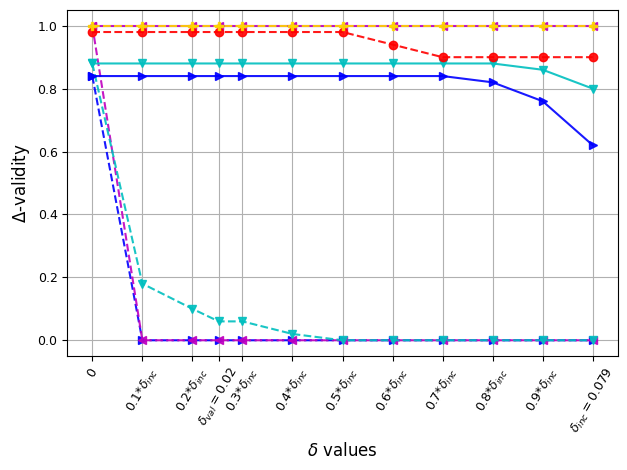

In [19]:
plot_delta_validity(deltas_plot, val_delta, gce_delta_validity, mce_delta_validity, proto_delta_validity, roar_delta_validity, gcer_delta_validity, mcer_delta_validity, protor_delta_validity, rnce_delta_validity, True, data_name)

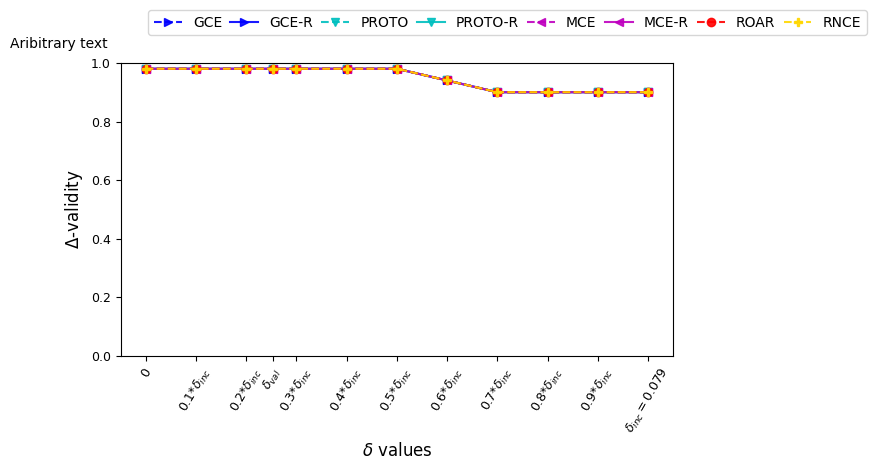

In [20]:
plot_delta_validity_lgd(deltas_plot, val_delta, roar_delta_validity,roar_delta_validity,roar_delta_validity,roar_delta_validity,roar_delta_validity,roar_delta_validity,roar_delta_validity,roar_delta_validity)

## Experiments 3

Benchmarking CEs

Performance drops after consecutive runs, save and load results after restartting

In [21]:
from intabs.evaluation import *
from intabs.methods import run_exps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
rt_models_eval = get_retrained_models_all(d, model, num_h_neurons=num_h_neurons, epochs=epochs)

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


In [22]:
from intabs.methods import run_exps_all_once
res_1 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=1050,
                               run_id=1)


===== running experiments 1/5 =====
===== running non-robust baselines 1-4/17 =====


20it [13:48, 41.41s/it]


===== running robust baselines 5-7/17 =====


20it [01:40,  5.04s/it]
20it [00:00, 44.24it/s]
20it [00:01, 18.64it/s]


===== running our methods 8-12/17, incremental delta =====


20it [03:01,  9.07s/it]
20it [00:40,  2.03s/it]
20it [42:40, 128.03s/it]
5659it [02:53, 32.53it/s]
20it [00:11,  1.71it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:25,  4.26s/it]
20it [00:11,  1.71it/s]
20it [18:25, 55.25s/it]
5659it [01:48, 52.27it/s]
20it [00:06,  2.90it/s]


In [23]:
res_2 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=7050,
                               run_id=2)

===== running experiments 2/5 =====
===== running non-robust baselines 1-4/17 =====


20it [19:55, 59.76s/it]


===== running robust baselines 5-7/17 =====


20it [01:53,  5.66s/it]
20it [00:00, 46.20it/s]
20it [00:00, 25.18it/s]


===== running our methods 8-12/17, incremental delta =====


20it [03:14,  9.73s/it]
20it [01:14,  3.73s/it]
20it [1:11:24, 214.25s/it]
5659it [04:37, 20.41it/s]
20it [00:18,  1.07it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:50,  5.54s/it]
20it [00:18,  1.09it/s]
20it [39:20, 118.03s/it]
5659it [03:07, 30.19it/s]
20it [00:10,  1.92it/s]


In [24]:
res_3 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3050,
                               run_id=3)

===== running experiments 3/5 =====
===== running non-robust baselines 1-4/17 =====


20it [33:20, 100.04s/it]


===== running robust baselines 5-7/17 =====


20it [01:43,  5.16s/it]
20it [00:00, 36.82it/s]
20it [00:01, 17.95it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:59,  9.00s/it]
20it [01:37,  4.90s/it]
20it [1:58:03, 354.19s/it]
5659it [05:57, 15.82it/s]
20it [00:28,  1.43s/it]


===== running our methods 13-17/17, validation delta =====


20it [01:39,  4.96s/it]
20it [00:22,  1.11s/it]
20it [1:03:12, 189.62s/it]
5659it [03:40, 25.68it/s]
20it [00:13,  1.47it/s]


In [22]:
res_4 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3990,
                               run_id=4)

===== running experiments 4/5 =====
===== running non-robust baselines 1-4/17 =====


20it [09:12, 27.62s/it]


===== running robust baselines 5-7/17 =====


20it [01:46,  5.31s/it]
20it [00:00, 62.89it/s]
20it [00:00, 30.12it/s]


===== running our methods 8-12/17, incremental delta =====


20it [03:19, 10.00s/it]
20it [00:16,  1.24it/s]
20it [25:53, 77.66s/it]
5659it [01:12, 78.42it/s]
20it [00:05,  3.42it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:56,  5.81s/it]
20it [00:04,  4.14it/s]
20it [12:39, 38.00s/it]
5659it [00:51, 109.87it/s]
20it [00:04,  4.57it/s]


In [14]:
res_5 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=6666,
                               run_id=5)

===== running experiments 5/5 =====
===== running non-robust baselines 1-4/17 =====
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14


0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]
[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]


20it [09:55, 29.79s/it]


===== running robust baselines 5-7/17 =====


20it [02:10,  6.54s/it]
20it [00:00, 52.00it/s]
20it [00:00, 26.69it/s]


===== running our methods 8-12/17, incremental delta =====


20it [03:01,  9.07s/it]
20it [00:15,  1.25it/s]
20it [30:24, 91.21s/it] 
5659it [01:05, 86.46it/s]
20it [00:05,  3.58it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:30,  4.55s/it]
20it [00:04,  4.27it/s]
20it [12:36, 37.80s/it]
5659it [00:55, 101.41it/s]
20it [00:04,  4.55it/s]


In [41]:
mean_res, std_res = run_exps(res_1, res_2, res_3, res_4, res_5)

average results
+--------------+------------+--------+-------+-------+--------------+--------------+
| name         |   coverage |   cost |   lof |   vm2 |   vdelta-val |   vdelta-inc |
+==============+============+========+=======+=======+==============+==============+
| gce          |       1    |  0.039 | 3.054 | 0.265 |        0     |        0     |
| mce          |       1    |  0.019 | 1.79  | 0.256 |        0     |        0     |
| proto        |       0.91 |  0.144 | 1.662 | 0.507 |        0.066 |        0     |
| nnce         |       1    |  0.028 | 1.298 | 0.433 |        0.08  |        0     |
| roar         |       0.96 |  0.388 | 8.44  | 1     |        1     |        0.947 |
| rbr          |       1    |  0.038 | 1.529 | 0.983 |        0.38  |        0     |
| stable-ce    |       1    |  0.039 | 1.228 | 0.999 |        0.74  |        0     |
| gce-r        |       1    |  0.109 | 3.615 | 0.87  |        0.87  |        0.67  |
| mce-r        |       1    |  0.096 | 2.81  | 1 